# Image procecessing

In [1]:
import numpy as np
from skimage import  data
from skimage import filters
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage import io
import skimage.graph as gh
from skimage.color import rgb2gray
import skimage.graph

In [2]:
%matplotlib inline

# First Method Seam Carver Using  Dynamic programming

In [16]:
def compute_energy_function(InputImg):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
        
    Returns
    =======
    output : the Energy map of the image based on  after delete on gradient    
    """
    gray = rgb2gray(InputImg)
    enargy = skimage.filters.rank.gradient(gray,disk(3))
    
    return enargy

def compute_the_cumulative_energy(energy):
    """
    Parameters
    ==========
    
    input : energy 2-D numpy.array energy of the image
    
    Returns
    =======
    
    output : seam_paths : the least energy path from
            the first row tell the end of the energy matrix
    
            seam_path_energies : the cumulative_energy of every seam_path  
    
    """
    #initilized variable to save the cumulative_energy computation 

    height, width = energy.shape
    
    seam_paths = np.zeros((height, width),dtype=np.int64)
    
    seam_path_energies = np.zeros((height, width),dtype=np.int64)
    
    seam_path_energies[0] = energy[0]
    
    seam_paths[0] = np.arange(width) * np.nan

    
    
    for i in range(1, height):
        for j in range(width):
            # all possible direction of the seam to take from adjacent neighbourhood 
            previous_energy = seam_path_energies[i-1, max(j-1, 0):j+2] 
            # choose the direction of the neighbourhood whith the min energy cost
            lowest_energy_sum = previous_energy.min() 
             # update the the cumulative_energy of every seam_path
            seam_path_energies[i][j] = energy[i][j] + lowest_energy_sum
             # update the the indices of every seam_path
            seam_paths[i][j] = np.where(previous_energy == lowest_energy_sum)[0][0] - (1*(j != 0))

    return seam_paths, seam_path_energies

def compute_the_seam_end_index(seam_path_energies):
    """
    Parameters
    ==========
    
    input : seam_paths matrix of the seam_paths
    
    Returns
    =======
    
      output : the end index of the seam path with the minimum energy 
    """
    return list(seam_path_energies[-1]).index(min(seam_path_energies[-1]))


def find_seam_indices(seam_paths, seam_end):
    """
    Parameters
    ==========
    input : seam_paths 2-D numpy.array(int64)
        Output of cumulative_energy_map. Each element of the matrix is the offset of the index to
        the previous pixel in the seam
    seam_end : The x-coordinate of the end of the seam
    
    Returns
    =======
    output : the path of the seam with the lowest energy   
    """
    height, width = seam_paths.shape[:2]
    seam = [seam_end]
    for i in range(height-1, 0, -1):
        x = seam[-1]
        x_prev = seam_paths[i][x]
        seam.append(x + x_prev)
    seam.reverse()
    return seam


def remove_one_seam(InputImg, seam):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
           seam: the seam array from find_seam_indices
        
    Returns
    =======
    output : image after delete one seam and reshaped 
    """
    height, width = InputImg.shape[:2]
    
    return np.array([np.delete(InputImg[row], seam[row], axis=0) for row in range(height)])



def delete_vertical_seam(InputImage,nrow):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
    input: nrow number of rows to delete 
        
    Returns
    =======
    output :  2D or 3-D image as numpy.array
    """
    
    OutputImg = InputImage.copy()
    
    for i in range(nrow):
            
            en =compute_energy_function(OutputImg)
            paths, cumsum = compute_the_cumulative_energy(en)
            seam = find_seam_indices(paths, compute_the_seam_end_index(cumsum))
            OutputImg = remove_one_seam(OutputImg,seam)
    return OutputImg


def delete_horizontal_seam(InputImage,ncol):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
    input: ncol number of colums to delete 
        
    Returns
    =======
    output :  2D or 3-D image as numpy.array    
    """
    
    OutputImg = InputImage.copy()
    R_OutputImg = np.rot90(OutputImg)
    
    for i in range(ncol):
        en = compute_energy_function(R_OutputImg)
        paths, cumsum = compute_the_cumulative_energy(en)
        seam = find_seam_indices(paths, compute_the_seam_end_index(cumsum))
        R_OutputImg = remove_one_seam(R_OutputImg,seam)
            
    R1_OutputImg = np.rot90(R_OutputImg)
    R2_OutputImg = np.flipud(R1_OutputImg)
    R3_OutputImg = np.fliplr(R2_OutputImg)
            
            
    return R3_OutputImg

def delete_both_horizontal_and_vertical_seam(InputImage, nrow, ncol):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
    input: nrow number of rows to delete 
    input: ncol number of columns to delete 
        
    Returns
    =======
    output :  2D or 3-D image as numpy.array    
    """
    
    OutputImg = InputImage.copy()
    
    for i in range(max(nrow, ncol)):
        if nrow > 0:
            OutputImg = delete_vertical_seam(OutputImg, 1)
            nrow -= 1
        if ncol > 0:
            OutputImg = delete_horizontal_seam(OutputImg, 1)
            ncol -= 1
            
    return OutputImg



def draw_seam(InputImage):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
   
    Returns
    =======
    output :  2D or 3-D image as numpy.array with the seam idetfy 
    
    """
    OutputImg = InputImage.copy()
    R_OutputImg = np.rot90(OutputImg)
    en = compute_energy_function(R_OutputImg)
    paths, cumsum = compute_the_cumulative_energy(en)
    seam = find_seam_indices(paths, compute_the_seam_end_index(cumsum))
    fig, ax = plt.subplots()
    ax.plot(seam, '-', linewidth=2, color='blue')
    ax.imshow(InputImage,cmap='gray')
    
    

In [4]:
def resizeImage(InputImage,ncol,nrow):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
           ncol: the seam array from find_seam_indices
        
    Returns
    =======
    output : image after delete one seam and reshaped 
    
    """
    OutputImg = InputImage.copy()
    
    if(ncol>0):
        OutputImg = delete_horizontal_seam(OutputImg,ncol)
    
    if(nrow>0):
        OutputImg = delete_vertical_seam(OutputImg,nrow)
        
                
    return OutputImg
        
 

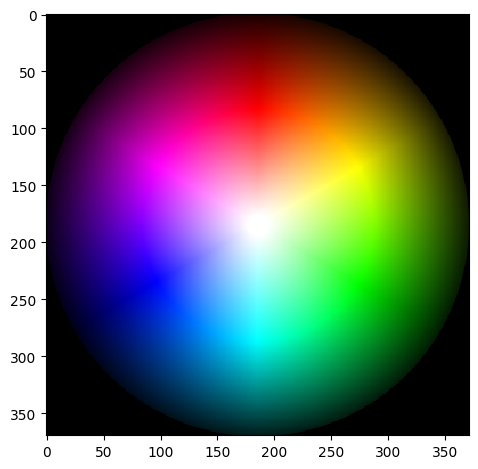

In [8]:
ImageTest = data.colorwheel()
io.imshow(ImageTest);

In [17]:
SeamImageTest= delete_both_horizontal_and_vertical_seam(ImageTest,50,50)

/tmp/ipykernel_19551/1352828416.py:134: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  en =compute_energy_function(OutputImg)
/tmp/ipykernel_19551/1352828416.py:46: RuntimeWarning: invalid value encountered in cast
  seam_paths[0] = np.arange(width) * np.nan
/tmp/ipykernel_19551/1352828416.py:157: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  en = compute_energy_function(R_OutputImg)


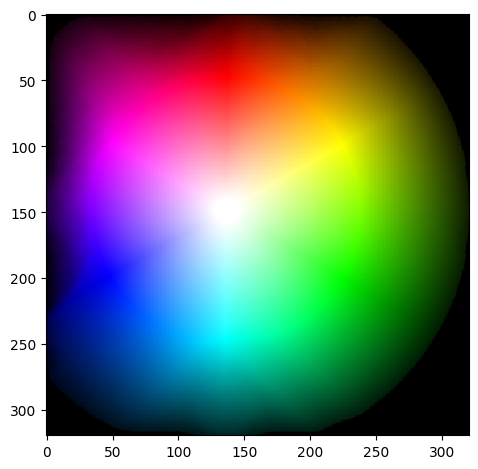

In [18]:
io.imshow(SeamImageTest);

# Second Method Seam Carver Using  Graph Theroy 

We will apply Dijkstra's minimum cost path algorithm,for use with data on a n-dimensional to find the mnimum path in the energy image and consedr it as a seam for Seam Carver Method 

In [21]:

def delete_vertical_Graph_seam(InputImage,nrow):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
    input: nrow number of rows to delete 
        
    Returns
    =======
    output :  2D or 3-D image as numpy.array
    """
    OutputImg = InputImage.copy()
    
    for i in range(nrow):
            en =compute_energy_function(OutputImg)
            paths, cumsum = compute_the_cumulative_energy(en)
            seam = find_seam_indices(paths, compute_the_seam_end_index(cumsum))
            OutputImg = remove_one_seam(OutputImg,seam)
    return OutputImg


def delete_horizontal_Graph_seam(InputImage,ncol):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
    input: ncol number of colums to delete 
        
    Returns
    =======
    output :  2D or 3-D image as numpy.array    
    """
    OutputImg = InputImage.copy()
    R_OutputImg = np.rot90(OutputImg)
    
    for i in range(ncol):
        en =compute_energy_function(R_OutputImg)
        indices, weight = skimage.graph.shortest_path(en,reach=1,output_indexlist=False)
        seam_graph = np.array(indices)
        R_OutputImg = remove_one_seam(R_OutputImg,seam_graph)
            
    R1_OutputImg = np.rot90(R_OutputImg)
    R2_OutputImg = np.flipud(R1_OutputImg)
    R3_OutputImg = np.fliplr(R2_OutputImg)
            
            
    return R3_OutputImg



def draw_Graph_seam(InputImage):
    """
    Parameters
    ==========
    input: InputImg  2D or 3-D image as numpy.array 
   
    Returns
    =======
    output :  2D or 3-D image as numpy.array with the seam idetfy 
    
    """
    OutputImg = InputImage.copy()
    R_OutputImg = np.rot90(OutputImg)
    en = compute_energy_function(R_OutputImg)
    paths, cumsum = compute_the_cumulative_energy(en)
    seam = find_seam_indices(paths, compute_the_seam_end_index(cumsum))
    fig, ax = plt.subplots()
    ax.plot(seam, '-', linewidth=2, color='blue')
    ax.imshow(InputImage,cmap='gray')
    
    

## compare time between the two method 

/tmp/ipykernel_19551/550669516.py:16: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  en =compute_energy_function(OutputImg)
/tmp/ipykernel_19551/1352828416.py:46: RuntimeWarning: invalid value encountered in cast
  seam_paths[0] = np.arange(width) * np.nan
/tmp/ipykernel_19551/550669516.py:38: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  en =compute_energy_function(R_OutputImg)


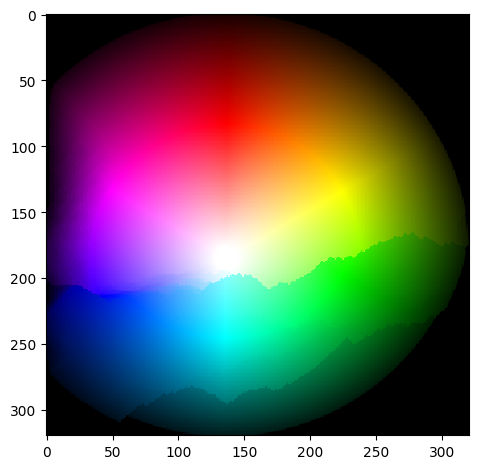

In [22]:
image = data.colorwheel()
image_vertical = delete_vertical_Graph_seam(image,50)
image_final = delete_horizontal_Graph_seam(image_vertical,50)
io.imshow(image_final);

# Timing it and comparing the speeds of the two methods

In [601]:
%timeit IO1 = delete_horizontal_Graph_seam(ImageTest,20)

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


3.72 s ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [602]:
%timeit IO2 = delete_horizontal_seam(ImageTest,20)

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1min 36s ± 4.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [603]:
SeamGraphImageTest = delete_vertical_Graph_seam(ImageTest,100)

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


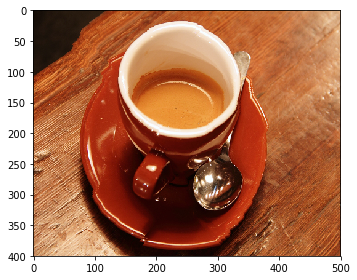

In [604]:
io.imshow(SeamGraphImageTest)

# Visual test for the two seam method 


In [149]:
# Visual test for the two seam method 

image = skimage.data.coffee()
img = np.rot90(image)
gray1 = rgb2gray(img)
gray2 = rgb2gray(image)
myenargy1 = skimage.filters.rank.gradient(gray1,disk(3))
myenargy2 = skimage.filters.rank.gradient(gray2,disk(3))


a,b = compute_the_cumulative_energy(myenargy1)
s = find_seam_indices(a, compute_the_seam_end_index(b))


/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [150]:
# calculate the shorest path 

indices, weight = skimage.graph.shortest_path(myenargy2,reach=1,output_indexlist=False)


seam_graph = np.array(indices)



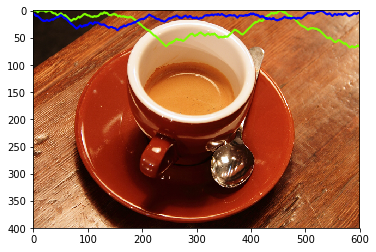

In [257]:

fig, ax = plt.subplots()
ax.plot(s, '-', linewidth = 2, color='chartreuse') # normal seam 
ax.plot(seam_graph, '-', linewidth=2, color='blue') # Graph seam
ax.imshow(image,cmap='gray')


# Hough Masked Seam is the best method for seam carver

In [1]:
%pip install seam-carving

In [2]:
import cv2
import numpy as np
import seam_carving

# Read the source image
src = cv2.imread("Image/image1.jpegimage.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

# Apply the Canny edge detector
edges = cv2.Canny(gray, 50, 150)

# Apply the Hough transform to find the lines
lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

# Create a mask image with the same size as the source image
mask = np.zeros_like(src)

# Draw the lines on the mask image
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Resize the image using seam carving with the mask
dst = seam_carving.resize(src, size=(src.shape[1] - 100, src.shape[0]), keep_mask=mask)

# Show the original and the resized images
cv2.imshow("Original", src)
cv2.imshow("Resized", dst)
cv2.waitKey(0)
cv2.destroyAllWindows()


[ WARN:0@6.366] global loadsave.cpp:248 findDecoder imread_('Image/image1.jpegimage.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [113]:
from skimage.feature import canny
from skimage.draw import line
from skimage.transform import probabilistic_hough_line as hough
from skimage import transform
from skimage import morphology
from skimage.morphology import disk
from skimage import data
from skimage.feature import canny

lena = rgb2gray(data.astronaut()) # Replace "lena" with the appropriate image variable or import the "lena" image from the skimage library
print(lena.shape)

Canny_image = canny(lena, sigma=10, low_threshold=0.05, high_threshold=0.1)
print(Canny_image)

'''
Parameters description
----------------------
Sigma = to eliminate the noise of an image (the noisier the image, the greater the sigma)
low_threshold = Values below would have less probability of being an edge
high_threshold = Pixels above would'''



hough_lines = hough(Canny_image, threshold=5, line_length=5, line_gap=10)

'''

Parameters
----------
Threshold = How strong the line should be to be detected
Line_length = Minimum accepted length of detected lines. Increase to extract longer lines.
line_gap = Maximum gap between pixels to still form a line.
'''
def Hough_mask(InputImage):
    
    Canny_image = canny((lena),sigma=1.,low_threshold=0.05, high_threshold=0.3)
    
    hough_lines = hough(Canny_image,threshold=100, line_length=150, line_gap=10)
    
    image_hough = np.zeros((InputImage.shape[0],InputImage.shape[1]))
    
    for line in hough_lines:
        p0, p1 = line
        p0 = list(map(int, p0))
        p1 = list(map(int, p1))
        rr, cc = line(p0[0], p0[1], p1[0], p1[1])
        image_hough[rr, cc] = 1
    return image_hough

# show the image 
io.imshow(Hough_mask(imageeee))

(512, 512)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


TypeError: 'tuple' object is not callable

In [107]:
io.imshow(Hough_mask(image))

TypeError: 'tuple' object is not callable

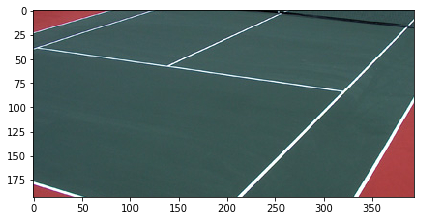

In [678]:
T1 = delete_vertical_seam(tennis,50)


/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


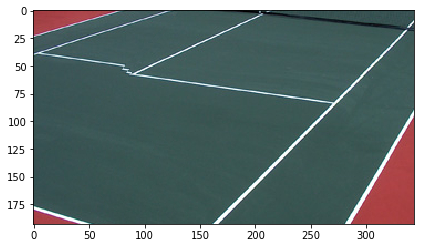

In [679]:
io.imshow(T1)

In [700]:
def apply_masked_vertical_seam(InputImage,nrow):
    OutputImg = InputImage.copy()
    
    for i in range(nrow):
            
            en =compute_energy_function(OutputImg)
            Mask = Hough_mask(rgb2gray(OutputImg))
            hough_mask = img_as_ubyte(Mask)
            
            paths, cumsum = compute_the_cumulative_energy(en+(hough_mask*50))
            seam = find_seam_indices(paths, compute_the_seam_end_index(cumsum))
            OutputImg = remove_one_seam(OutputImg,seam)
    return OutputImg


In [731]:
T2 = apply_masked_seam(tennis,50)

/home/eljazri/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


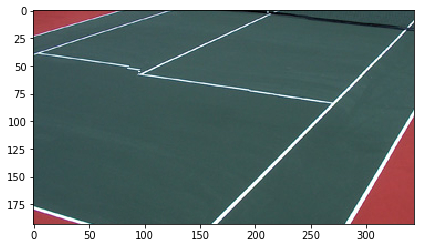

In [732]:
io.imshow(T2)